# Pure pursuit racing example

In [1]:
cd ..

/home/vjose/code/robotics-sandbox-py


In [2]:
import json

import scipy
import numpy as np
import cvxpy
import matplotlib.pyplot as plt
from shapely.geometry import *

import utils.track_utils as utils

# Import Track file

/home/vjose/code/robotics-sandbox-py/utils/track_utils.py:68: RuntimeWarning: divide by zero encountered in true_divide
  inv_slopes = -1.0 / slopes


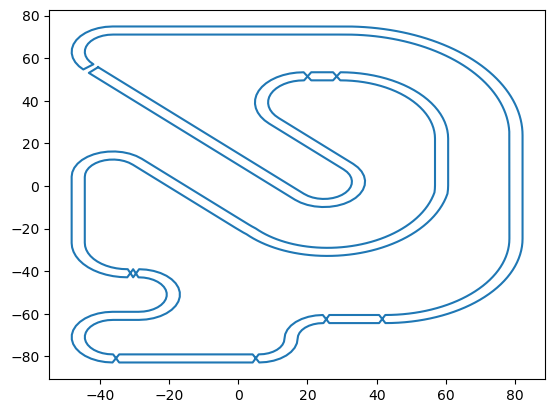

In [3]:
scale_factor = 50.0
with open('tracks/track.json', 'r') as f:
    data = json.load(f)
centerline_x, centerline_y = np.array(data['X']), np.array(data['Y'])
centerline = scale_factor* np.hstack((centerline_x[:, None], centerline_y[:, None]))

polygon = utils.centerline_to_polygon(centerline)
plt.plot(*polygon.T)

# Define car model

In [4]:
from scipy import optimize
from collections import defaultdict

def angle_diff(x, y):
    return (x - y + np.pi) % (2*np.pi) - np.pi

def car_dot(state: np.array, u: np.array, params: dict):
    """ Dynamics for a kinematic bicycle model of 1 meter length
    
    https://borrelli.me.berkeley.edu/pdfpub/IV_KinematicMPC_jason.pdf
    
    state description: 0: x, 1: y, 2: theta, 3: v
    input_description: 0: acc, 1: steer
    """
    
    wheel_base = params["wheel_base"]
    
    beta = np.arctan(0.5 * np.tan(u[1]))
    
    x_dot = state[3] * np.cos(state[2] + beta)
    y_dot = state[3] * np.sin(state[2] + beta)
    theta_dot = 2 * state[3] * np.sin(beta) / wheel_base
    v_dot = u[0]
    state_dot = [x_dot, y_dot, theta_dot, v_dot]
    
    return np.array(state_dot)

def controller(state: np.array, centerline: np.array, params: dict, information: defaultdict):
    
    lookahead_distance = params['lookahead_distance']
    lookahead_gain = params['lookahead_gain']
    steer_gain = params['steer_gain']
    wheel_base = params['wheel_base']
    target_speed = params['target_speed']
    
    centerline_lr = LinearRing(centerline)
    
    # Get rear axle
    rear_x = state[0] - (wheel_base / 2) * np.cos(state[2])
    rear_y = state[1] - (wheel_base / 2) * np.sin(state[2])
    point_rear = Point(rear_x, rear_y)
    tang_dist = centerline_lr.project(point_rear)
    
    # Get current point on centerline for search
    current_point = centerline_lr.interpolate(tang_dist)
    
    # Update Lookahead distance depending on speed
    lookahead = lookahead_gain * state[3] * lookahead_distance
    
    def distance(point_rear, current_point):
        return np.hypot(current_point.y - point_rear.y, 
                        current_point.x - point_rear.x)
    # Make circle bigger until you reached the desired lookahead
    dist = distance(point_rear, current_point)
    while lookahead > dist:
        tang_dist = (tang_dist + 1) % centerline_lr.length
        current_point = centerline_lr.interpolate(tang_dist)
        dist = distance(point_rear, current_point)

    # Pure pursuit https://arxiv.org/pdf/1604.07446.pdf 
    alpha_ref = np.arctan2((current_point.y - point_rear.y), 
                           (current_point.x - point_rear.x))
    
    # Get theta in -pi pi range
    theta = np.arctan2(np.sin(state[2]), np.cos(state[2]))
    
    alpha = angle_diff(alpha_ref, theta)
    curvature = 2 * np.sin(alpha) / lookahead_distance
    
    # Constant acceleration
    steer = steer_gain * np.arctan2(curvature * wheel_base, 1)
    accel = target_speed - state[3]
    
    information["opt_tan_dist"].append(tang_dist)
    information["alpha_ref"].append(alpha_ref)
    information["alpha"].append(alpha)
    information["lookahead_computed"].append(dist)
    information["lookahead"].append(lookahead)
    information["lookahead_points"].append(current_point)
    return np.array([accel, steer])

def get_state_trajectory(information, state_keys):
    state_trajectory = defaultdict(list)
    for state in information["state"]:
        for i, k in enumerate(state_keys):
            state_trajectory[k].append(state[i])
    return state_trajectory

def get_input_trajectory(information, input_keys):
    input_trajectory = defaultdict(list)
    for inputs in information["inputs"]:
        for i, k in enumerate(input_keys):
            input_trajectory[k].append(inputs[i])
    return input_trajectory

## Simulate and plot trajectory

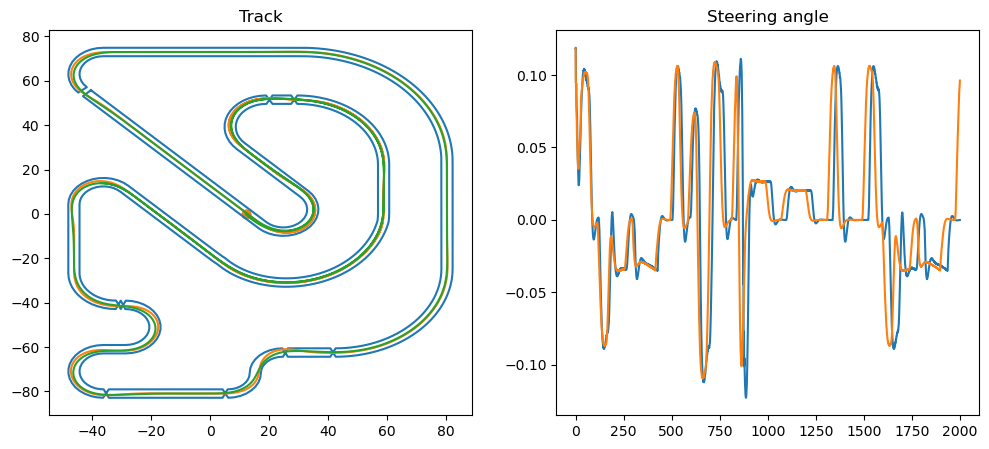

In [5]:
import copy
from collections import namedtuple
    
initial_state = np.array([12.0, 0, -1.0, 0.5])
delta_t = 0.1

# Plot track
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(*polygon.T)

for gain in np.linspace(0.8, 1.2, 2):
    params = dict(lookahead_distance=1.0,
                  lookahead_gain=gain,
                  steer_gain=0.15,
                  wheel_base=1,
                  target_speed=6.0)

    information = defaultdict(list)
    state = copy.deepcopy(initial_state)

    for _ in range(2000):
        inputs = controller(state, centerline, params, information)
        state = state + delta_t * car_dot(state, inputs, params)

        information["state"].append(state)
        information["inputs"].append(inputs)

    state_keys = ['x', 'y', 'theta', 'v']
    state_trajectory = get_state_trajectory(information, state_keys)

    input_keys = ['accel', 'steer']
    input_trajectory = get_input_trajectory(information, input_keys)

    ax[0].plot(state_trajectory['x'], state_trajectory['y'])
    ax[0].set_title("Track")
    ax[1].plot(input_trajectory['steer'])
    ax[1].set_title("Steering angle")
    ax[0].scatter([initial_state[0],], [initial_state[1],])
        
plt.show()

## Hybrid A star

DISTANCE_TO_FRONT = 3.3
DISTANCE_TO_BACK = 1.0

WHEELBASE = 3.0
WIDTH = 2.0


In [71]:
from dataclasses import dataclass

@dataclass
class VehicleConfiguration:
    wheelbase_m = 3.0
    width_m = 2.0
    distance_to_front_axle_m = 3.3 
    distance_to_rear_axle_m = 1.0 
    max_steer_m = 0.6
    timestep_s = 0.1

VEHICLE_CONFIG = VehicleConfiguration()

#     W_BUBBLE_DIST = (LF - LB) / 2.0
#     W_BUBBLE_R = sqrt(((LF + LB) / 2.0) ** 2 + 1)

# Get corners of the vehicle for plotting
x_corners = [VEHICLE_CONFIG.distance_to_front_axle_m, 
             VEHICLE_CONFIG.distance_to_front_axle_m, 
             -VEHICLE_CONFIG.distance_to_rear_axle_m, 
             -VEHICLE_CONFIG.distance_to_rear_axle_m,
             VEHICLE_CONFIG.distance_to_front_axle_m]
y_corners = [VEHICLE_CONFIG.width_m / 2, 
             -VEHICLE_CONFIG.width_m / 2, 
             -VEHICLE_CONFIG.width_m / 2, 
             VEHICLE_CONFIG.width_m / 2, 
             VEHICLE_CONFIG.width_m / 2]

def wrap_angle(angle):
    return (angle + jnp.pi) % (2 * jnp.pi) - jnp.pi

def speed_controlled_car_step(state, action, timestep_s, wheelbase_m):
    state_next = jnp.zeros_like(state)
    state_next = state_next.at[0].set(state[0] + timestep_s * action[0] * jnp.cos(state[2]))
    state_next = state_next.at[1].set(state[1] + timestep_s * action[0] * jnp.sin(state[2]))
    state_next = state_next.at[2].set(state[2] + timestep_s * action[0] * jnp.tan(action[1]) / wheelbase_m)
    return state_next


class SpeedControlledCar(object):
    def __init__(self, config):
        self.config = config
        self.jitted_dynamics = jit(_speed_controlled_car_step)
        self.jitted_state_jacobian_wrt_state = jit(jacfwd(_speed_controlled_car_step, argnums=0))
        self.jitted_state_jacobian_wrt_action = jit(jacfwd(_speed_controlled_car_step, argnums=1))

    def step(self, state, action):
        return self.jitted_dynamics(state, action, self.config.timestep_s, self.config.wheelbase_m)
    
    def get_A_matrix(self, state, action):
        return self.jitted_state_jacobian_wrt_state(state, action, self.config.timestep_s, self.config.wheelbase_m)
    
    def get_B_matrix(self, state, action):
        return self.jitted_state_jacobian_wrt_action(state, action, self.config.timestep_s, self.config.wheelbase_m)

DeviceArray([[0.05403023, 0.        ],
             [0.0841471 , 0.        ],
             [0.05191359, 0.11418396]], dtype=float32)